# How to see what your agent did ?

## I General plotting utilities

With the module "grid2op.PlotGrid" (more information on the official documentation [here](https://grid2op.readthedocs.io/en/latest/plotgrid.html)) we offer some possibility to inspect visually (**aka** plot) some informations about the state of the powergrid.

This module counts today 2 "base" classes:
- `PlotMatplotlib` which uses the well-known matplotlib python library to render the plot. Matplotlib being the most used plotting library in python, we decided to add its support in grid2op.
- `PlotPlotly` that uses the plotply librairy. Plotly is particularly suited for making in depth study of some particular time step.

It is not recommended to use any of these. Rather, we developped two higher level classes:
- `EpisodeReplay` which uses the "PlotMatplotlib" class internally and is used to render a movie "as a gif or a mp4 file mainly for communication about the results of your agent
- `env.render` which is the familiar method for all people used to the open ai gym framework.

Last but not least, a package called `grid2viz` has been developped to help you diagnose in depth the behaviour of your agent. This package is much more advance than all the methods presented above and we highly recommend its usage to get the best of your agents!

In [1]:
import matplotlib.pyplot as plt  # pip install matplotlib
import seaborn as sns # pip install seaborn
import plotly.graph_objects as go  # pip install plotly
import imageio  # pip install imageio

This notebook will not work if one of the 6 packages above cannot be imported. We then highly recommend you to install them on your machine. (we put the pip command to install them if you have any trouble)

In [2]:
import grid2op
env = grid2op.make("rte_case14_realistic", test=True)

/home/tezirg/Code/Grid2Op.BDonnot/getting_started/grid2op/MakeEnv/Make.py:223: UserWarning:

You are using a development environment. This environment is not intended for training agents.



## II Plot.Plotting utility

As we already said, the "Plot.Plotting" module can help render a powergrid using 3 different methods: pygame, matplotlib or plotly. The display method is defined when you create a "plotting" object as shown bellow.

All functions exposed here are available for pygame, plotly and matplotlib. Fill free to switch from one to the other in order to see the differences.


### II A) Plot Static informations
The next cell will plot the names of each object on the powergrid, as well as their id.

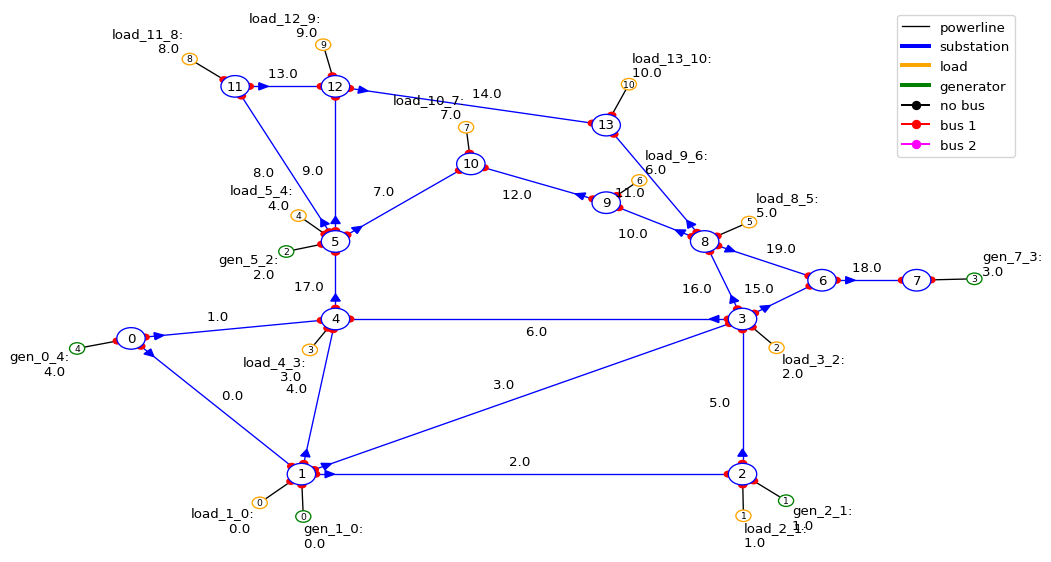

In [3]:
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)
fig_layout = plot_helper.plot_layout()

It is also possible to display some "external" information on this layout, for example, you can plot the thermal limit of each powerlines:

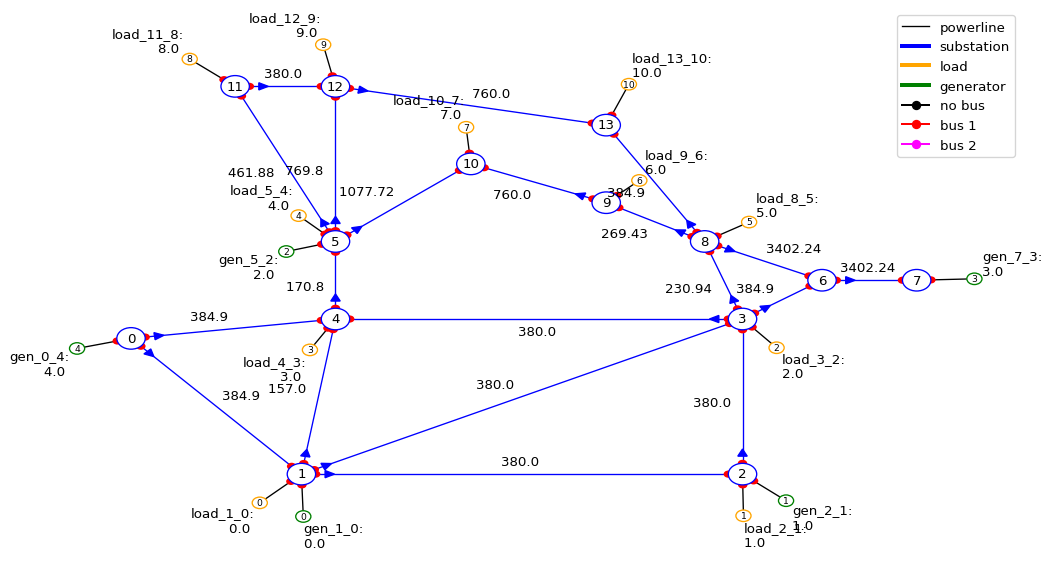

In [4]:
fig_info = plot_helper.plot_info(line_values=env._thermal_limit_a)

The argument "line_values" shows that you want to plot information about powerlines (here the thermal limit). 

It is also possible to display information abouts loads and generators in the same manner.

### II B) Plot a few observations


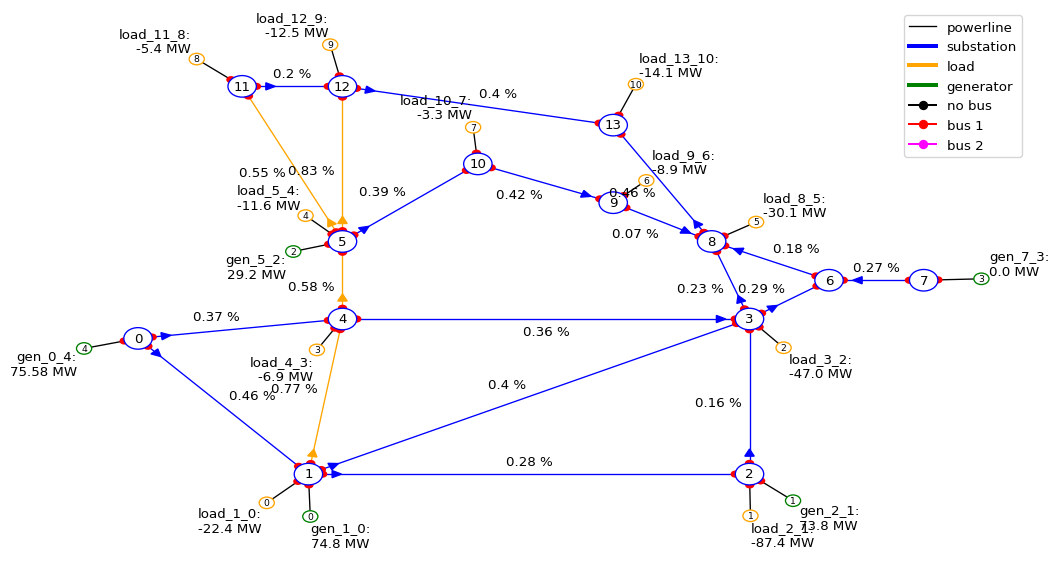

In [5]:
obs = env.reset()
fig_obs = plot_helper.plot_obs(obs)

Here you can see that the powerlines are colored with respect to their flow (in % of the thermal limit). Load and generator information are provided with the injection (+ for generators, - for loads) given in MW. All that can be modified as showed in the cell below where we plot the active power flow for the powerline and the load voltage magnitude for the load. Notice that the units will be modified, and so will the colormap.

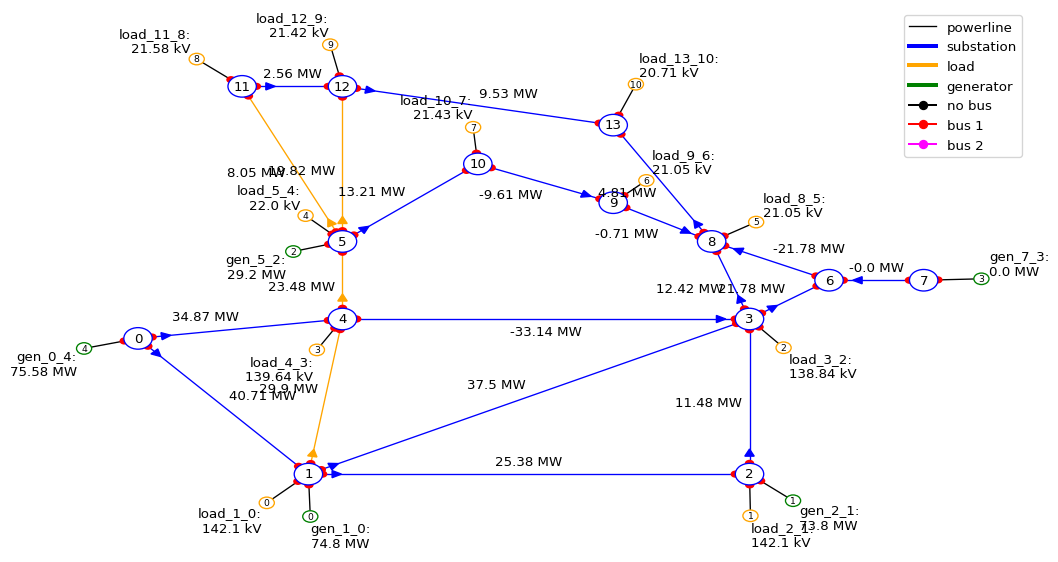

In [6]:
fig_obs2 = plot_helper.plot_obs(obs, line_info="p", load_info="v")

Finally, the topology at each substation can also be plotted. For example, let's take a topological action at substation 1.

We will move the load there (with a voltage magnitude of 142.1kV, the powerline with 42.1MW and the powerline with 40.4MW to the bus number 2. This can be done easily, for example by looking at their id on the first layout, and apply the appropriate action (see notebook [2_Action_GridManipulation](2_Action_GridManipulation.ipynb) for more information).

In [7]:
action = env.action_space({"set_bus": {"loads_id": [(0,2)], "lines_or_id": [(3,2)], "lines_ex_id": [(0,2)]}})
print(action)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 2 to line (extremity) 0 [on substation 1]
	 	 - assign bus 2 to line (origin) 3 [on substation 1]
	 	 - assign bus 2 to load 0 [on substation 1]


The `print` utility helps us check the action we implemented was the one we wanted to implement. `print` is also a nice way to see what happened sometimes.

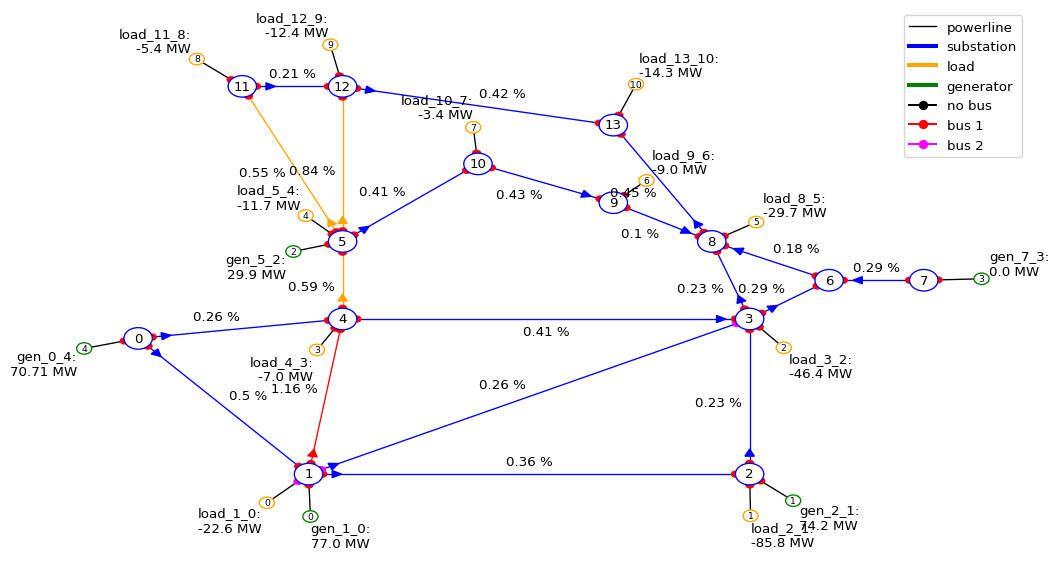

In [8]:
new_obs, reward, done, info = env.step(action)
fig_obs3 = plot_helper.plot_obs(new_obs)

On the red bus are connected all the object that have not moved. It is the bus 1.

On the magenta bus we see the connected the objects that have been moved to this bus, so the load 0, the "origin" of powerline 3, and the "extremity" of powerline 0. 

This plotting utility is a pretty usefull tool to detect what happened, especially just before a game over.

## III env.render

Another mode to inspect what is going on "in live" is to use the render. The renderer can be used as in any open ai gym environment. 

In the next cell we will: reset the environment created above, create an agent that takes random actions every 10 timesteps and see how it goes (we take care to use this agent instead of the bare "RandomAgent" because most of the time a RandomAgent games over at the first or second time step...).

**NB** It is not recommended to train your agent with any renderer turned on. The preferred way is to train your agent without any renderer in a first step, and in a second step to evaluate your agent on a fixed set of scenarios with possibily the renderer on (see the next section about that).

/home/tezirg/Code/Grid2Op.BDonnot/getting_started/grid2op/Environment/Environment.py:582: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



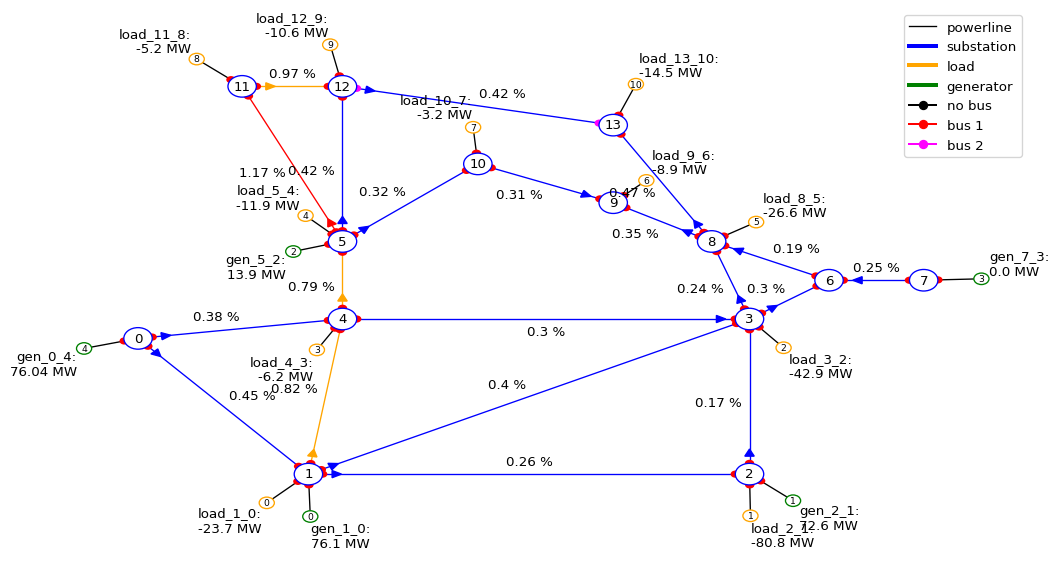

In [9]:
from grid2op.Agent import RandomAgent
class CustomRandom(RandomAgent):
    def __init__(self, action_space):
        RandomAgent.__init__(self, action_space)
        self.i = 1

    def my_act(self, transformed_observation, reward, done=False):
        if (self.i % 10) != 0:
            res = 0
        else:
            res = self.action_space.sample()
        self.i += 1
        return res
    
myagent = CustomRandom(env.action_space)
obs = env.reset()
reward = env.reward_range[0]
done = False
while not done:
    env.render()
    act = myagent.act(obs, reward, done)
    obs, reward, done, info = env.step(act)
env.close()

## IV ReplayEpisode

This tool allows you to save gif of the "renderer" of your agent in an offline manner. We recommend, as stated above, to get rid of any renderer in the training phase, and then to use the runner to assess the performance of your agent using a runner, and with the saved results of the runner, to start this class, or to study it more in depth with grid2viz (see next section). 

But first things first, let's mimic what we think is a good process. Suppose you are happy with the result of your agent (for the sake of simplicity, we will not train any agent here, but we will rather use the CustomRandom class here). Now what do you do ?

First, you create an environment on which it will be evaluated, and the associated runner:

In [10]:
from grid2op.Runner import Runner
env = grid2op.make(test=True)
my_awesome_agent = CustomRandom(env.action_space)
runner = Runner(**env.get_params_for_runner(), agentClass=None, agentInstance=my_awesome_agent)

/home/tezirg/Code/Grid2Op.BDonnot/getting_started/grid2op/MakeEnv/Make.py:223: UserWarning:

You are using a development environment. This environment is not intended for training agents.



Second, you start the runner and save the result in a given directory (here we limit the runner to perform 30 iterations to gain time):

In [11]:
import os
path_agents = "path_agents"  # this is mandatory for grid2viz to have a directory with only agents
# that is why we have it here. It is aboslutely not mandatory for this more simple class.
max_iter = 30  # to save time we only assess performance on 30 iterations
if not os.path.exists(path_agents):
    os.mkdir(path_agents)
path_awesome_agent_log = os.path.join(path_agents, "awesome_agent_logs")
res = runner.run(nb_episode=2, path_save=path_awesome_agent_log, max_iter=max_iter)

Third, you use the results of the runner to save the results as gif for example (you can also visualize it offline on the screen if you prefer for that you simply need to switch the "display" argument to ``True``

In [14]:
%%capture
from grid2op.Episode import EpisodeReplay
gif_name = "episode"
ep_replay = EpisodeReplay(agent_path=path_awesome_agent_log)
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    ep_replay.replay_episode(chron_name,  # which chronic was started
                             gif_name=gif_name, # Name of the gif file
                             display=False,  # dont wait before rendering each frames
                             fps=3.0)  # limit to 3 frames per second

And you can even see the gif in the jupyter notebook afterwards

This only works if:
- you haven't changed path_awesome_agent_log
- you haven't changed the name of gif_name
- all the above cells have be run properly

![img](./path_agents/awesome_agent_logs/000/episode.gif)

## V Grid2Viz

This tool is a really usefull tool to deep dive into the anylisis of your agent. We highly recommend you use it to develop always stronger agent and score high in the competition.

Grid2viz is a package that has been developped to help you visualize the behaviour of your agent. 

It is available for now in a github repository [grid2viz](https://github.com/mjothy/grid2viz). In the few following cells we will demonstrate how to use it to inspect in more detail the log of the agents generated by the runner (second cell of this notebook).


We will first run some other agents to show the full potential of grid2viz (optional). Then we emphasize a constraint on the use of grid2viz: the folder tree must respect a certain order. Then we show how to install it and finally how to launch it on the data generated by this notebook.

![](https://raw.githubusercontent.com/mjothy/grid2viz/master/grid2viz/assets/screenshots/scenario_overview.png)

### V1 More agents to compare

This section is not mandatory, but it is better to show the full capabilities of grid2viz. We will first run 2 others agents: the do nothing agent, and the topology greedy agents.

In [13]:
# make a runner for this agent
from grid2op.Agent import DoNothingAgent, TopologyGreedy
import shutil

for agentClass, agentName in zip([DoNothingAgent],  # , TopologyGreedy
                                 ["DoNothingAgent"]):  # , "TopologyGreedy"
    path_this_agent = os.path.join(path_agents, agentName)
    shutil.rmtree(os.path.abspath(path_this_agent), ignore_errors=True)
    runner = Runner(**env.get_params_for_runner(),
                    agentClass=agentClass
                    )
    res = runner.run(path_save=path_this_agent, nb_episode=2, 
                    max_iter=max_iter)
    print("The results for the {} agent are:".format(agentName))
    for _, chron_id, cum_reward, nb_time_step, max_ts in res:
        msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
        msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
        msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
        print(msg_tmp)

The results for the DoNothingAgent agent are:
	For chronics with id 000
		 - cumulative reward: 34403.382277
		 - number of time steps completed: 30 / 30
	For chronics with id 001
		 - cumulative reward: 34420.375574
		 - number of time steps completed: 30 / 30


###  V.2 Installation

Grid2Viz is not yet on pypi, the python package repository. So you need a specific command to install it. It can be done super easily by running the cell bellow (more information can be found on the grid2iz github).

In [14]:
import sys
print("To install it, either uncomment the cell bellow, or type, in a command prompt:\n{}".format(
    ("\t{} -m pip install git+https://github.com/mjothy/grid2viz.git --user --extra-index-url https://test.pypi.org/simple/".format(sys.executable))))

To install it, either uncomment the cell bellow, or type, in a command prompt:
	/usr/bin/python3.6 -m pip install git+https://github.com/mjothy/grid2viz.git --user --extra-index-url https://test.pypi.org/simple/


In [15]:
# !$sys.executable -m pip install git+https://github.com/mjothy/grid2viz --user --extra-index-url https://test.pypi.org/simple/

### V.3 Usage

Once the above package is installed, you can now start to study what your agent did (NB the agent must have been run with a runner and the "path_save" argument in order for grid2viz to work properly.

For performance optimization, grid2viz uses a cache. This notebook being an example, it is recommended to clear the cache before starting the grid2viz app. Of course, if you study different generation of your agent, it is NOT recommended to clear the cache before any study.

In [16]:
shutil.rmtree(os.path.join(os.path.abspath(path_agents), "_cache"), ignore_errors=True)

In [ ]:
!$sys.executable -m grid2viz.main --path=$path_agents